# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = '/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(hue=.06, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'valid': torchvision.transforms.Compose([        
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': torchvision.datasets.ImageFolder(
        'flower_data/train',
        transform=data_transforms['train']
    ),
    'valid': torchvision.datasets.ImageFolder(
        'flower_data/valid',
        transform=data_transforms['valid']
    )
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=256,
        shuffle=True,
        num_workers=16
    ),
    'valid': torch.utils.data.DataLoader(
        image_datasets['valid'],
        batch_size=256,
        shuffle=True,
        num_workers=16
    )
}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
def create_model(device=torch.device('cpu')):
    model = torchvision.models.resnet152(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    num_features = model.fc.in_features
    
    fc_layers = torch.nn.Sequential(OrderedDict([
        ('fc1', torch.nn.Linear(num_features, 1024)),
        ('relu1', torch.nn.ReLU()),
        ('dropout1', torch.nn.Dropout(p=0.4)),
        ('fc2', torch.nn.Linear(1024, 512)),
        ('relu2', torch.nn.ReLU()),
        ('dropout2', torch.nn.Dropout(p=0.4)),
        ('fc3', torch.nn.Linear(512, 256)),
        ('relu3', torch.nn.ReLU()),
        ('dropout3', torch.nn.Dropout(p=0.4)),
        ('fc4', torch.nn.Linear(256, 102)),
        ('output', torch.nn.LogSoftmax(dim=1))
    ]))
    model.fc = fc_layers
    
    model.to(device)
    
    return model


In [7]:
model = create_model(device)


In [8]:
def train_model(densenet, criterion, optimizer, num_epochs):
    perfs = []
    
    best_loss = +np.inf
    dataset_sizes = {
        'train': len(image_datasets['train']),
        'valid': len(image_datasets['valid'])
    }
    
    for epoch in range(num_epochs):
        train_epoch_loss = 0
        train_epoch_acc = 0
        valid_epoch_loss = 0
        valid_epoch_acc = 0
        
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_corrects = 0
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                if phase == 'train':
                    densenet.train(True)
                else:
                    densenet.train(False)
                
                inputs = torch.autograd.Variable(inputs.to(device=device))
                labels = torch.autograd.Variable(labels.to(device=device))
                
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()
                
                del inputs, labels, outputs, preds
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
        
        print('Epoch [{}/{}] train loss: {:.6f} acc: {:.6f} valid loss: {:.6f} acc: {:.6f}'.format(
            epoch + 1, num_epochs, train_epoch_loss, train_epoch_acc, valid_epoch_loss, valid_epoch_acc))
        
        perfs.append([train_epoch_loss, train_epoch_acc, valid_epoch_loss, valid_epoch_acc])
        
        if valid_epoch_loss < best_loss:
            print("Model improved (from loss: {:.6f} to {:.6f}), saving ".format(best_loss, valid_epoch_loss))
            best_loss = valid_epoch_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'class_to_idx': image_datasets['train'].class_to_idx
            }, 'checkpoint.pth.tar')
    
    print("Training completed - Best loss: {:.6f}".format(best_loss))
    
    perfs_df = pd.DataFrame(perfs, columns=['train_epoch_loss',
                                            'train_epoch_acc',
                                            'valid_epoch_loss',
                                            'valid_epoch_acc'])
    return perfs_df


In [9]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adadelta(model.fc.parameters(), lr=1.1, rho=0.8, eps=1e-07, weight_decay=0)


In [10]:
num_epochs = 200
perfs_df = train_model(model, criterion, optimizer, num_epochs)


Epoch [1/200] train loss: 0.017928 acc: 0.039225 valid loss: 0.020928 acc: 0.070905
Model improved (from loss: inf to 0.020928), saving 
Epoch [2/200] train loss: 0.016815 acc: 0.077839 valid loss: 0.018733 acc: 0.117359
Model improved (from loss: 0.020928 to 0.018733), saving 
Epoch [3/200] train loss: 0.015427 acc: 0.123016 valid loss: 0.015253 acc: 0.283619
Model improved (from loss: 0.018733 to 0.015253), saving 
Epoch [4/200] train loss: 0.013513 acc: 0.195055 valid loss: 0.013638 acc: 0.289731
Model improved (from loss: 0.015253 to 0.013638), saving 
Epoch [5/200] train loss: 0.011795 acc: 0.272131 valid loss: 0.012731 acc: 0.347188
Model improved (from loss: 0.013638 to 0.012731), saving 
Epoch [6/200] train loss: 0.010495 acc: 0.323107 valid loss: 0.008446 acc: 0.526895
Model improved (from loss: 0.012731 to 0.008446), saving 
Epoch [7/200] train loss: 0.009456 acc: 0.370421 valid loss: 0.007805 acc: 0.588020
Model improved (from loss: 0.008446 to 0.007805), saving 
Epoch [8/20

Epoch [79/200] train loss: 0.001494 acc: 0.899878 valid loss: 0.001302 acc: 0.943765
Epoch [80/200] train loss: 0.001471 acc: 0.898046 valid loss: 0.001380 acc: 0.931540
Epoch [81/200] train loss: 0.001386 acc: 0.909799 valid loss: 0.001464 acc: 0.942543
Epoch [82/200] train loss: 0.001450 acc: 0.899573 valid loss: 0.001511 acc: 0.941320
Epoch [83/200] train loss: 0.001409 acc: 0.902778 valid loss: 0.001173 acc: 0.931540
Epoch [84/200] train loss: 0.001478 acc: 0.896673 valid loss: 0.001378 acc: 0.937653
Epoch [85/200] train loss: 0.001471 acc: 0.900794 valid loss: 0.001229 acc: 0.947433
Epoch [86/200] train loss: 0.001422 acc: 0.898810 valid loss: 0.001423 acc: 0.940098
Epoch [87/200] train loss: 0.001424 acc: 0.901709 valid loss: 0.001077 acc: 0.943765
Model improved (from loss: 0.001115 to 0.001077), saving 
Epoch [88/200] train loss: 0.001369 acc: 0.905830 valid loss: 0.001315 acc: 0.935208
Epoch [89/200] train loss: 0.001403 acc: 0.903999 valid loss: 0.001190 acc: 0.949878
Epoch [

Epoch [172/200] train loss: 0.001004 acc: 0.931777 valid loss: 0.001371 acc: 0.942543
Epoch [173/200] train loss: 0.001035 acc: 0.931319 valid loss: 0.001186 acc: 0.943765
Epoch [174/200] train loss: 0.001094 acc: 0.932387 valid loss: 0.001195 acc: 0.943765
Epoch [175/200] train loss: 0.001047 acc: 0.928419 valid loss: 0.001144 acc: 0.952323
Epoch [176/200] train loss: 0.001031 acc: 0.932998 valid loss: 0.001351 acc: 0.951100
Epoch [177/200] train loss: 0.001074 acc: 0.928419 valid loss: 0.001637 acc: 0.944988
Epoch [178/200] train loss: 0.001101 acc: 0.930250 valid loss: 0.001157 acc: 0.946210
Epoch [179/200] train loss: 0.001050 acc: 0.933913 valid loss: 0.001151 acc: 0.937653
Epoch [180/200] train loss: 0.000962 acc: 0.934676 valid loss: 0.001298 acc: 0.938875
Epoch [181/200] train loss: 0.000984 acc: 0.936661 valid loss: 0.001317 acc: 0.942543
Epoch [182/200] train loss: 0.000996 acc: 0.934219 valid loss: 0.001101 acc: 0.946210
Epoch [183/200] train loss: 0.001124 acc: 0.923230 val

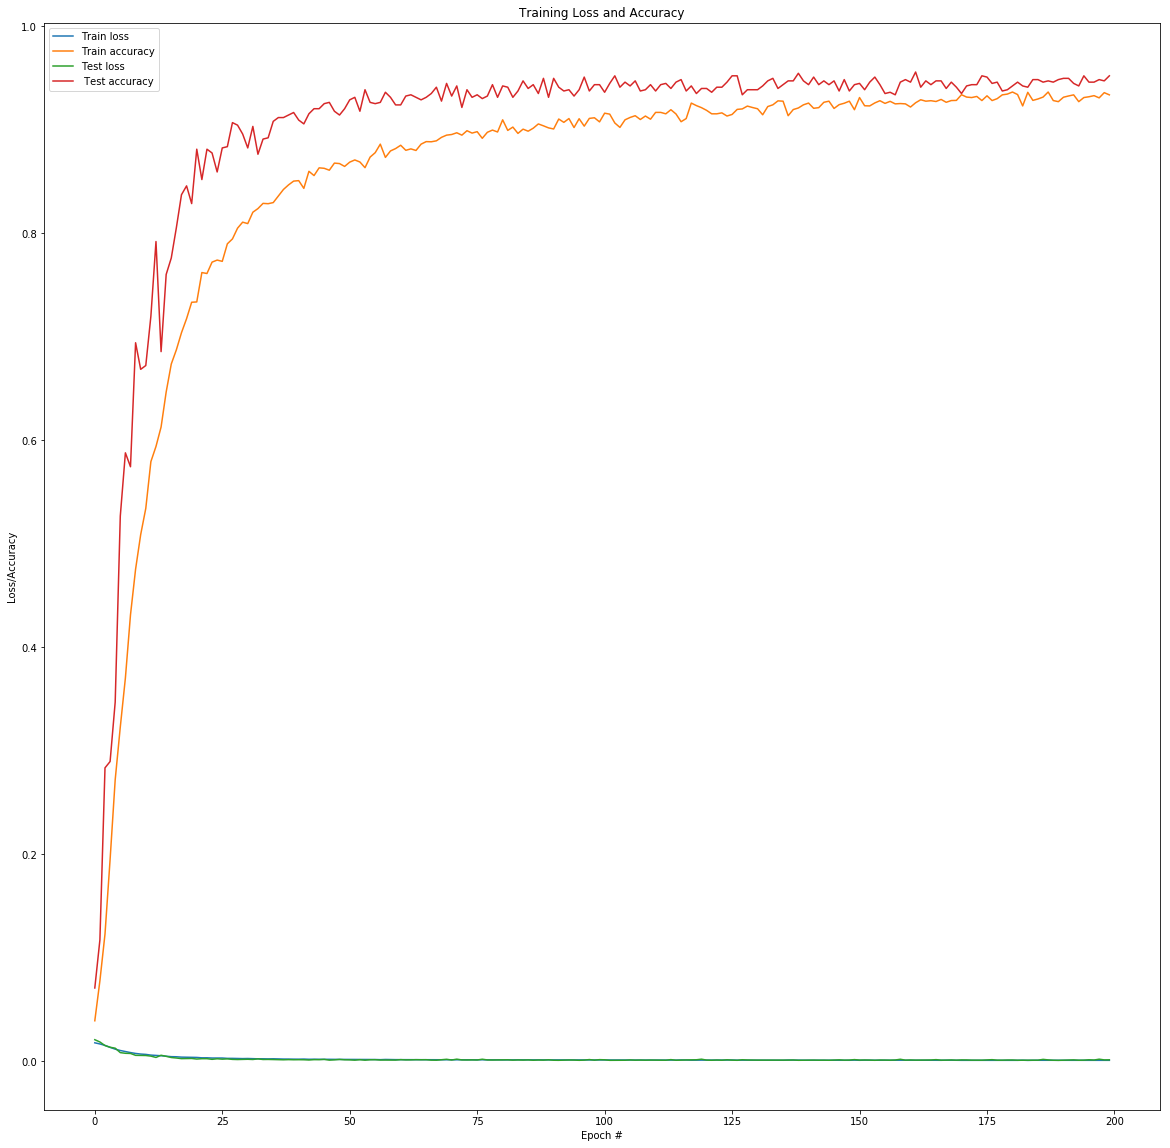

In [11]:
%matplotlib inline

plt.figure(figsize=(20, 20))
plt.plot(np.arange(0, num_epochs), perfs_df['train_epoch_loss'], label='Train loss')
plt.plot(np.arange(0, num_epochs), perfs_df['train_epoch_acc'], label='Train accuracy')
plt.plot(np.arange(0, num_epochs), perfs_df['valid_epoch_loss'], label='Test loss')
plt.plot(np.arange(0, num_epochs), perfs_df['valid_epoch_acc'], label=' Test accuracy')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


def load_checkpoint():
    model = create_model()
    optimizer = torch.optim.Adadelta(model.fc.parameters(), lr=1.1, rho=0.8, eps=1e-07, weight_decay=0)
    checkpoint = torch.load('checkpoint.pth.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    img = Image.open(image)
    img = preprocess(img)
    
    return img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [15]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.eval()
    model.cpu()
    
    image = process_image(image_path)
    image = image.unsqueeze(0)
    image = torch.autograd.Variable(image)
    
    with torch.no_grad():
        output = model.forward(image)
        probs = torch.exp(output)
        top_probs, top_labels = probs.topk(topk)
    
    return torch.Tensor.numpy(top_probs[0]).tolist(), torch.Tensor.numpy(top_labels[0]).tolist()


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

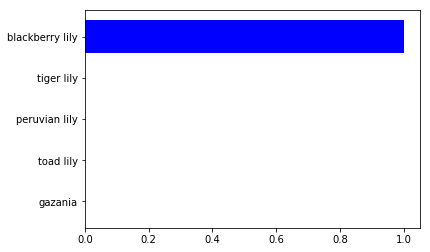

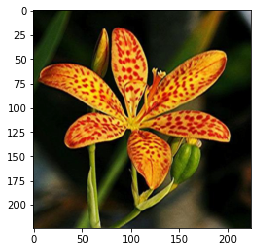

In [16]:
# TODO: Display an image along with the top 5 classes

%matplotlib inline
img_path = 'flower_data/valid/102/image_08014.jpg'

model, optimizer = load_checkpoint()
top_probs, top_labels = predict(img_path, model, topk=5)
idx_to_class = {val: key for key, val in model.class_to_idx.items()}

plt.barh([cat_to_name[idx_to_class[lab]] for lab in top_labels],
        top_probs,
        align='center', color='blue')
plt.gca().invert_yaxis()
plt.show()

imshow(process_image(img_path))
